In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^STOXX50E.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,3610.060059,3624.030029,3606.969971,3622.550049
2022-10-31 09:00:00+00:00,3613.570068,3617.320068,3608.479980,3610.179932
2022-10-31 10:00:00+00:00,3619.229980,3619.360107,3611.840088,3614.139893
2022-10-31 11:00:00+00:00,3616.199951,3623.199951,3614.709961,3619.350098
2022-10-31 12:00:00+00:00,3615.489990,3617.280029,3612.419922,3616.179932
...,...,...,...,...
2024-10-28 12:00:00+00:00,4953.330078,4954.899902,4932.609863,4938.370117
2024-10-28 13:00:00+00:00,4947.740234,4956.250000,4946.700195,4953.569824
2024-10-28 14:00:00+00:00,4966.339844,4968.569824,4941.839844,4947.729980


In [3]:
# dfi['date'] = pd.to_datetime(dfi['Time'])
# df = dfi.loc[dfi['date'] > '2024-07-19']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990
...,...,...,...,...
2024-10-28 12:00:00+00:00,4938.370117,4954.899902,4932.609863,4953.330078
2024-10-28 13:00:00+00:00,4953.569824,4956.250000,4946.700195,4947.740234
2024-10-28 14:00:00+00:00,4947.729980,4968.569824,4941.839844,4966.339844


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_29634/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_29634/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4527 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4527 non-null   float64
 1   High        4527 non-null   float64
 2   Low         4527 non-null   float64
 3   Close       4527 non-null   float64
 4   nxt_target  4527 non-null   float64
dtypes: float64(5)
memory usage: 212.2 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059,3613.570068
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068,3619.229980
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980,3616.199951
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951,3615.489990
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990,3616.129883
...,...,...,...,...,...
2024-06-06 14:00:00+00:00,5063.549805,5074.850098,5061.029785,5066.180176,5068.060059
2024-06-06 15:00:00+00:00,5066.200195,5070.649902,5064.680176,5068.060059,5066.669922
2024-06-07 07:00:00+00:00,5072.879883,5077.209961,5063.720215,5066.669922,5045.890137


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,3613.570068
2022-10-31 09:00:00+00:00,3619.229980
2022-10-31 10:00:00+00:00,3616.199951
2022-10-31 11:00:00+00:00,3615.489990
2022-10-31 12:00:00+00:00,3616.129883
...,...
2024-06-06 14:00:00+00:00,5068.060059
2024-06-06 15:00:00+00:00,5066.669922
2024-06-07 07:00:00+00:00,5045.890137


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990
...,...,...,...,...
2024-06-06 14:00:00+00:00,5063.549805,5074.850098,5061.029785,5066.180176
2024-06-06 15:00:00+00:00,5066.200195,5070.649902,5064.680176,5068.060059
2024-06-07 07:00:00+00:00,5072.879883,5077.209961,5063.720215,5066.669922


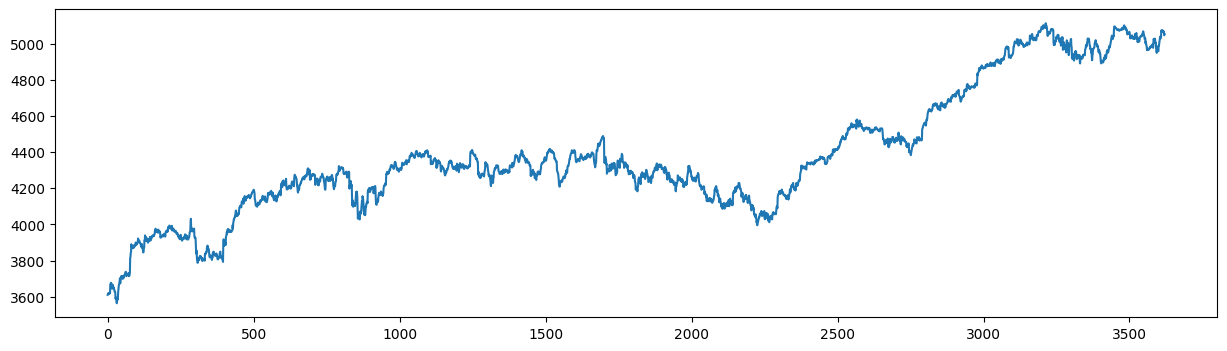

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

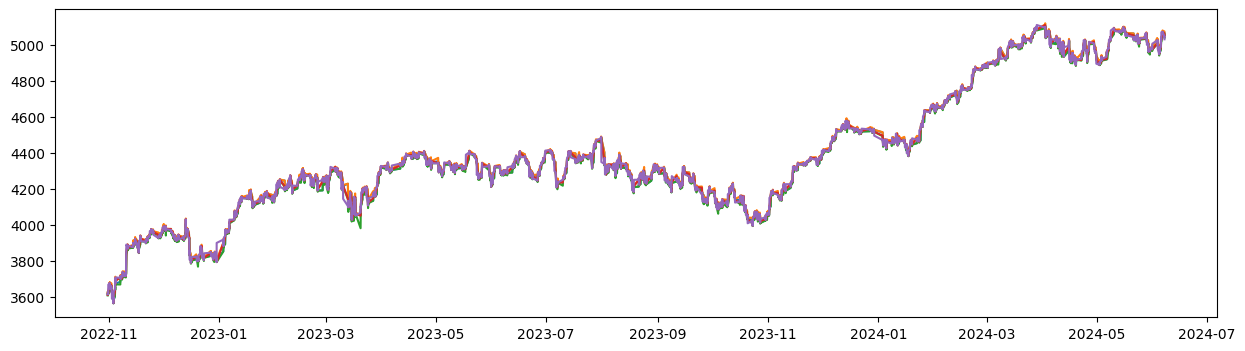

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3611, 10, 4])


tensor([-2.1921, -2.2106, -2.2138, -2.2296])

In [17]:
class QBLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QBLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget_f = [f"wire_forget_f{i}" for i in range(self.n_qubits)]
        self.wires_input_f = [f"wire_input_f{i}" for i in range(self.n_qubits)]
        self.wires_update_f = [f"wire_update_f{i}" for i in range(self.n_qubits)]
        self.wires_output_f = [f"wire_output_f{i}" for i in range(self.n_qubits)]

        self.wires_forget_b = [f"wire_forget_b{i}" for i in range(self.n_qubits)]
        self.wires_input_b = [f"wire_input_b{i}" for i in range(self.n_qubits)]
        self.wires_update_b = [f"wire_update_b{i}" for i in range(self.n_qubits)]
        self.wires_output_b = [f"wire_output_b{i}" for i in range(self.n_qubits)]

        self.dev_forget_f = qml.device(self.backend, wires=self.wires_forget_f)
        self.dev_input_f = qml.device(self.backend, wires=self.wires_input_f)
        self.dev_update_f = qml.device(self.backend, wires=self.wires_update_f)
        self.dev_output_f = qml.device(self.backend, wires=self.wires_output_f)

        self.dev_forget_b = qml.device(self.backend, wires=self.wires_forget_b)
        self.dev_input_b = qml.device(self.backend, wires=self.wires_input_b)
        self.dev_update_b= qml.device(self.backend, wires=self.wires_update_b)
        self.dev_output_b = qml.device(self.backend, wires=self.wires_output_b)

        def _circuit_forget_f(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget_f)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget_f)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget_f]
        self.qlayer_forget_f = qml.QNode(_circuit_forget_f, self.dev_forget_f, interface="torch")

        def _circuit_input_f(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input_f)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input_f)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input_f]
        self.qlayer_input_f = qml.QNode(_circuit_input_f, self.dev_input_f, interface="torch")

        def _circuit_update_f(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update_f)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update_f)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update_f]
        self.qlayer_update_f = qml.QNode(_circuit_update_f, self.dev_update_f, interface="torch")

        def _circuit_output_f(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output_f)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output_f)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_f]
        self.qlayer_output_f = qml.QNode(_circuit_output_f, self.dev_output_f, interface="torch")

        def _circuit_forget_b(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget_b)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget_b)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget_b]
        self.qlayer_forget_b = qml.QNode(_circuit_forget_b, self.dev_forget_b, interface="torch")

        def _circuit_input_b(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input_b)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input_b)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input_b]
        self.qlayer_input_b = qml.QNode(_circuit_input_b, self.dev_input_b, interface="torch")

        def _circuit_update_b(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update_b)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update_b)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update_b]
        self.qlayer_update_b = qml.QNode(_circuit_update_b, self.dev_update_b, interface="torch")

        def _circuit_output_b(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output_b)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output_b)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_b]
        self.qlayer_output_b = qml.QNode(_circuit_output_b, self.dev_output_b, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget_f': qml.qnn.TorchLayer(self.qlayer_forget_f, weight_shapes),
            'input_f': qml.qnn.TorchLayer(self.qlayer_input_f, weight_shapes),
            'update_f': qml.qnn.TorchLayer(self.qlayer_update_f, weight_shapes),
            'output_f': qml.qnn.TorchLayer(self.qlayer_output_f, weight_shapes),
            'forget_b': qml.qnn.TorchLayer(self.qlayer_forget_b, weight_shapes),
            'input_b': qml.qnn.TorchLayer(self.qlayer_input_b, weight_shapes),
            'update_b': qml.qnn.TorchLayer(self.qlayer_update_b, weight_shapes),
            'output_b': qml.qnn.TorchLayer(self.qlayer_output_b, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t_f = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t_f = torch.zeros(batch_size, self.hidden_size)  # cell state

            h_t_b = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t_b = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t_f, c_t_f = init_states
            h_t_f = h_t_f[0]
            c_t_f = c_t_f[0]

            h_t_b, c_t_b = init_states
            h_t_b = h_t_b[0]
            c_t_b = c_t_b[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t_f = x[:, t, :]

            # Concatenate input and hidden state
            v_t_f = torch.cat((h_t_f, x_t_f), dim=1)

            # match qubit dimension
            y_t_f = self.clayer_in(v_t_f)

            f_t_f = torch.sigmoid(self.clayer_out(self.VQC['forget_f'](y_t_f)))  # forget block
            i_t_f = torch.sigmoid(self.clayer_out(self.VQC['input_f'](y_t_f)))  # input block
            g_t_f = torch.tanh(self.clayer_out(self.VQC['update_f'](y_t_f)))  # update block
            o_t_f = torch.sigmoid(self.clayer_out(self.VQC['output_f'](y_t_f))) # output block

            c_t_f = (f_t_f * c_t_f) + (i_t_f * g_t_f)
            h_t_f = o_t_f * torch.tanh(c_t_f)


            # get features from the t-th element in seq, for all entries in the batch
            x_t_b = x[:, seq_length-t-1, :]

            # Concatenate input and hidden state
            v_t_b = torch.cat((h_t_b, x_t_b), dim=1)

            # match qubit dimension
            y_t_b = self.clayer_in(v_t_b)

            f_t_b = torch.sigmoid(self.clayer_out(self.VQC['forget_b'](y_t_b)))  # forget block
            i_t_b = torch.sigmoid(self.clayer_out(self.VQC['input_b'](y_t_b)))  # input block
            g_t_b = torch.tanh(self.clayer_out(self.VQC['update_b'](y_t_b)))  # update block
            o_t_b = torch.sigmoid(self.clayer_out(self.VQC['output_b'](y_t_b))) # output block

            c_t_b = (f_t_b * c_t_b) + (i_t_b * g_t_b)
            h_t_b = o_t_b * torch.tanh(c_t_b)

            h_t = (h_t_f + h_t_b)/2
            c_t = (c_t_f + c_t_b)/2
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [18]:
class QRegressionBLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QBLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [19]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionBLSTM(num_sensors=4, hidden_units= 6, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [20]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0
def new_func(x):
    output = modelQ(x)
    return output

for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = new_func(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:118.64448508152964 
[2/5]  LossQ:74.46253143725244 
[3/5]  LossQ:27.1107103896461 
[4/5]  LossQ:16.905368812612323 
[5/5]  LossQ:10.744313903429429 


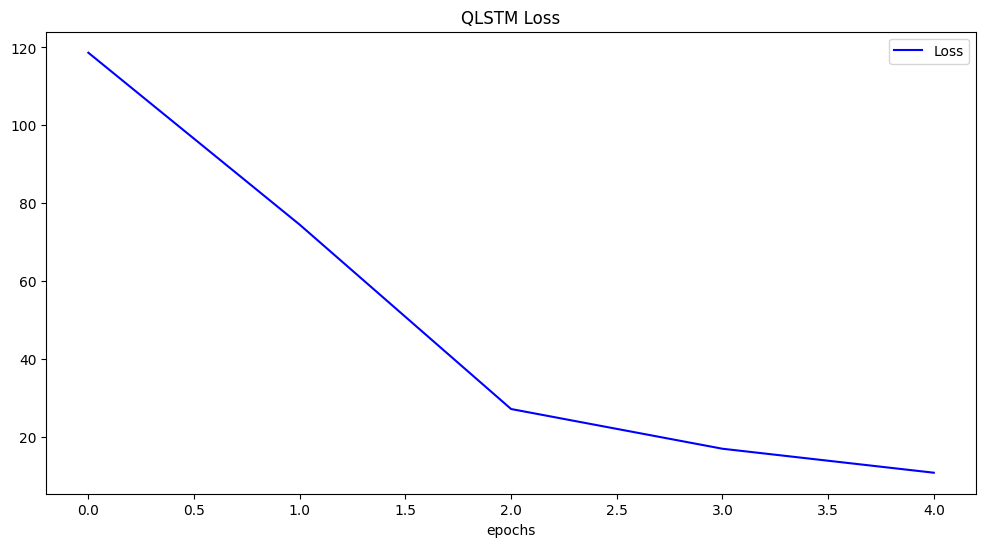

In [21]:
np.savetxt('./SavedModels/Stock/STOXX50E/loss/qblstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [22]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [23]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.9480, -0.9458, -0.9421,  ...,  1.9190,  1.8870,  1.8772],
       grad_fn=<ViewBackward0>)


In [24]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [25]:
pred_y_train

tensor([[-0.9480],
        [-0.9458],
        [-0.9421],
        ...,
        [ 1.9190],
        [ 1.8870],
        [ 1.8772]], grad_fn=<ViewBackward0>)

In [26]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [27]:
np.savetxt('./SavedModels/Stock/STOXX50E/train/qblstm.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/STOXX50E/test/qblstm.txt',y_test_pred)

Training dataset RMSE:156.89417137391524


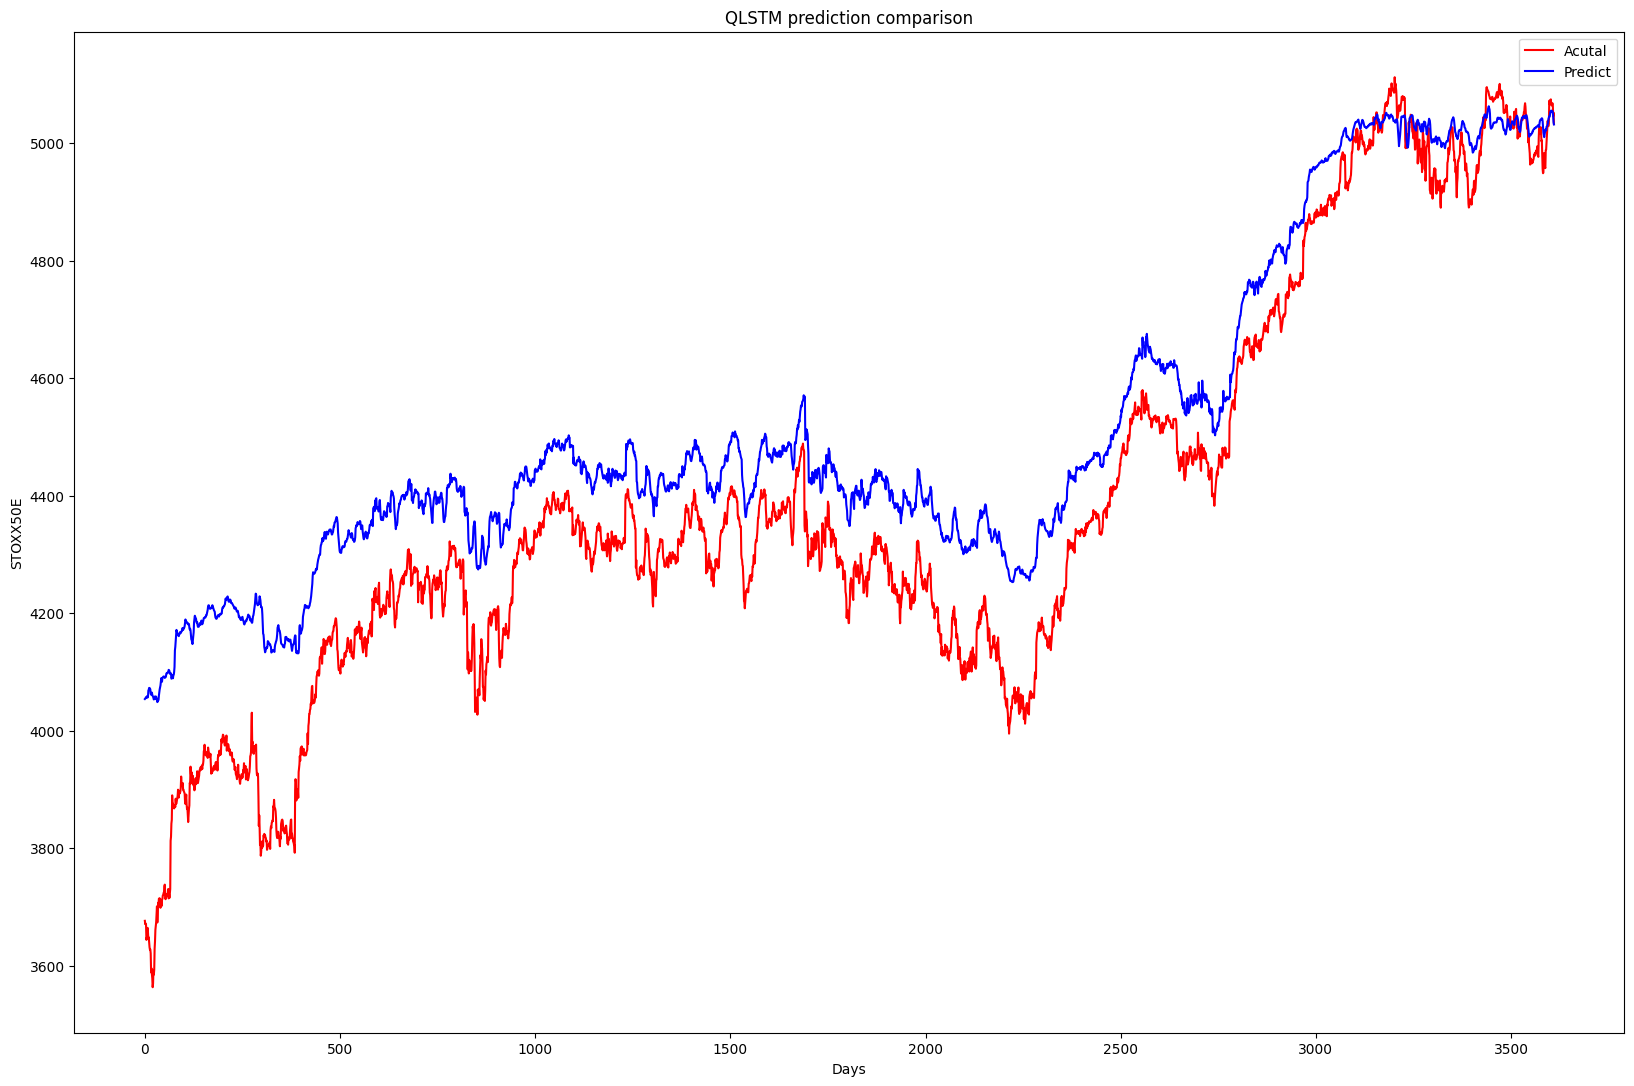

In [28]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('STOXX50E')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:66.96508868788003


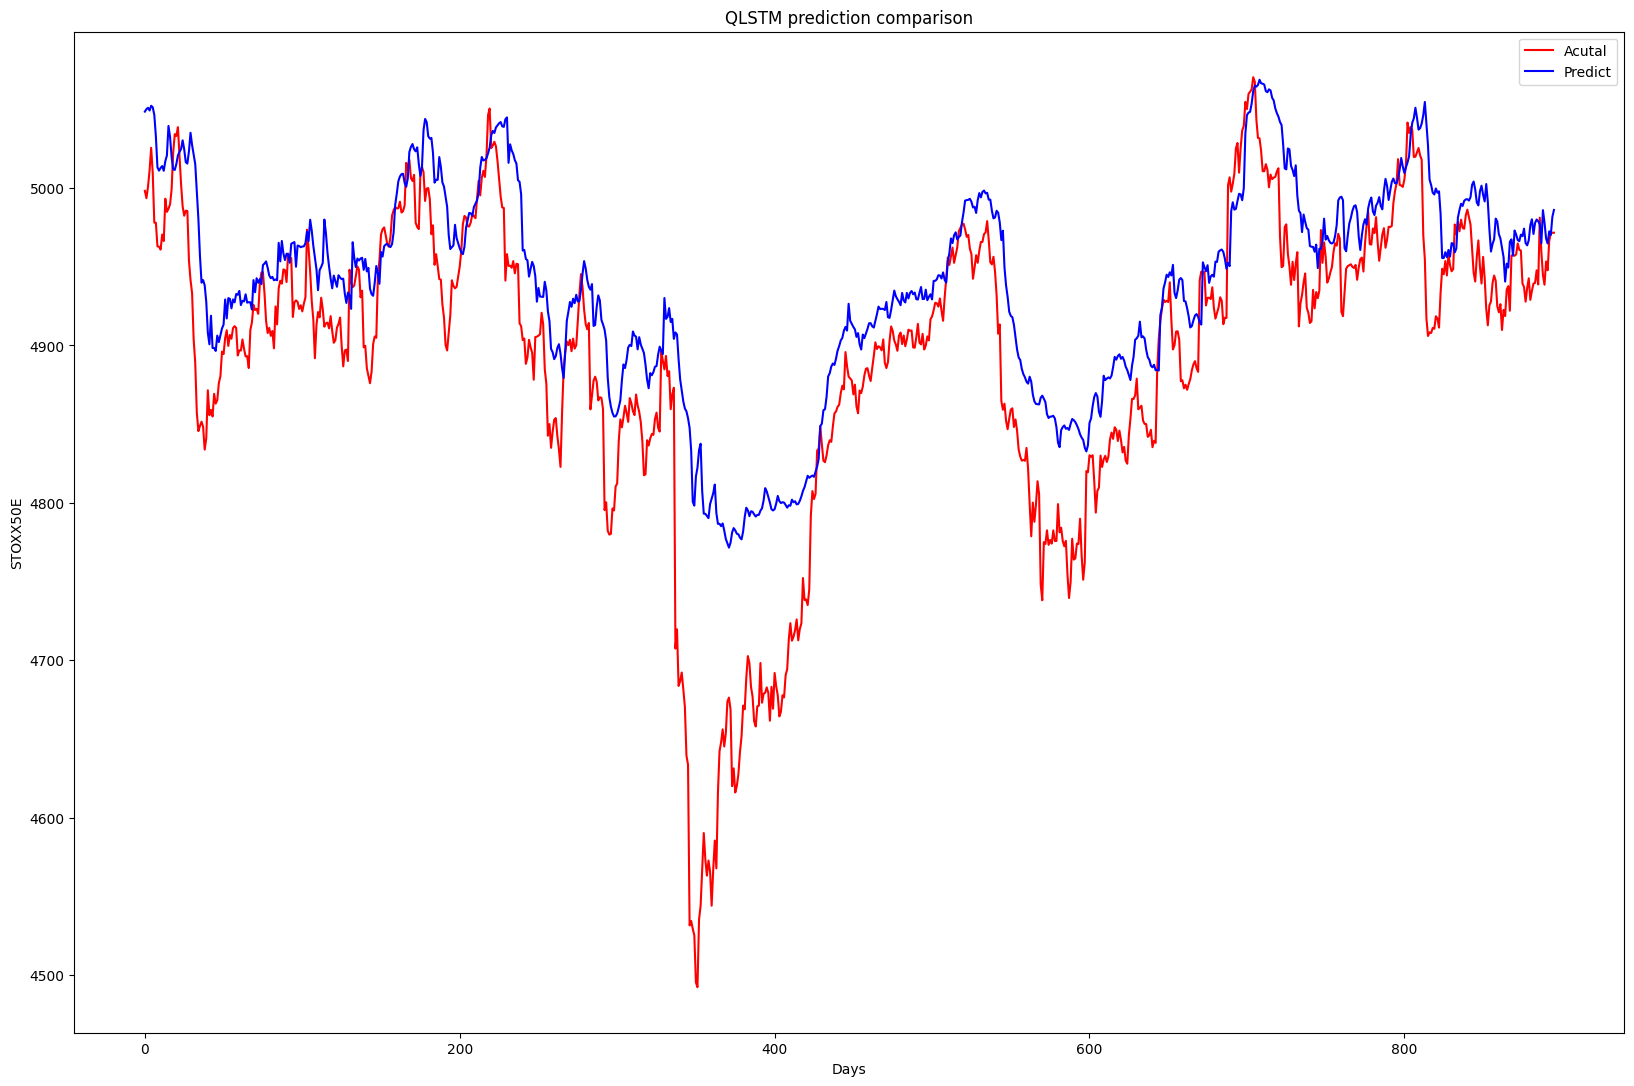

In [29]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('STOXX50E')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [30]:
torch.save(modelQ.state_dict(),'./SavedModels/Stock/STOXX50E/model/QBLSTM_sd')